# Grupo Trigo — MMM (Tratamento + Abordagem)
Este notebook organiza tratamento, feature engineering (adstock/saturação),
modelos (Ridge e Bayes hierárquico), validação e otimização

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
crm_df = pd.read_excel('data/CRM_Consolidado_Anon.xlsx', sheet_name='Sheet1')
faturamento_df = pd.read_excel('data/Faturamento.xlsx', sheet_name='result')
google_df = pd.read_excel('data/Google.xlsx', sheet_name='Google')
meta_df = pd.read_excel('data/Meta.xlsx', sheet_name='Raw Data Report')
vendas_df = pd.read_excel('data/Anon_Item_Venda.xlsx', sheet_name='Sheet1')

print("Dados carregados com sucesso!")
print(f"\nCRM: {crm_df.shape}")
print(f"Faturamento: {faturamento_df.shape}")
print(f"Google Ads: {google_df.shape}")
print(f"Meta Ads: {meta_df.shape}")
print(f"Vendas: {vendas_df.shape}")

Dados carregados com sucesso!

CRM: (538, 12)
Faturamento: (1244, 3)
Google Ads: (3865, 7)
Meta Ads: (14068, 8)
Vendas: (978039, 19)


# Tratamento Inicial dos Dados

### Análise Inicial - CRM Consolidado

In [4]:
print("\n" + "="*80)
print("ANÁLISE INICIAL - CRM CONSOLIDADO")
print("="*80)

print("\nInformações do Dataset:")
print(crm_df.info())

print("\nPrimeiras linhas:")
print(crm_df.head())

print("\nValores ausentes:")
print(crm_df.isnull().sum())

print("\nEstatísticas descritivas:")
print(crm_df.describe())


ANÁLISE INICIAL - CRM CONSOLIDADO

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Campanha_Anon  538 non-null    object 
 1   QtdDisparos    538 non-null    int64  
 2   VolumeDisparo  538 non-null    int64  
 3   Vendas         526 non-null    float64
 4   Vendas (%)     526 non-null    float64
 5   Conversao      526 non-null    float64
 6   Conversao (%)  526 non-null    float64
 7   Investimento   538 non-null    float64
 8   Faturamento    526 non-null    float64
 9   Margem         526 non-null    float64
 10  ROAS           538 non-null    float64
 11  time           538 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 50.6+ KB
None

Primeiras linhas:
     Campanha_Anon  QtdDisparos  VolumeDisparo  Vendas  Vendas (%)  Conversao  \
0  [CAMP_56e90a6d]           18          21796   76

### Limpeza - CRM Consolidado

In [5]:
print("\n" + "="*80)
print("LIMPEZA - CRM CONSOLIDADO")
print("="*80)

crm_clean = crm_df.copy()

crm_clean['time'] = pd.to_datetime(crm_clean['time'], errors='coerce')

numeric_cols = ['QtdDisparos', 'VolumeDisparo', 'Vendas', 'Vendas (%)',
                'Conversao', 'Conversao (%)', 'Investimento', 'Faturamento',
                'Margem', 'ROAS']

for col in numeric_cols:
    crm_clean[col] = pd.to_numeric(crm_clean[col], errors='coerce')

crm_clean['Campanha_Anon'] = crm_clean['Campanha_Anon'].astype(str).str.strip()

print(f"\nLinhas antes da limpeza: {len(crm_df)}")
print(f"Linhas após conversão de tipos: {len(crm_clean)}")

print("\nValores ausentes após limpeza:")
print(crm_clean.isnull().sum())

crm_clean = crm_clean.dropna(subset=['time', 'Investimento', 'Faturamento'])

print(f"Linhas após remover nulos críticos: {len(crm_clean)}")

crm_clean = crm_clean[crm_clean['Investimento'] >= 0]
crm_clean = crm_clean[crm_clean['Faturamento'] >= 0]
crm_clean = crm_clean[crm_clean['VolumeDisparo'] >= 0]

print(f"Linhas após remover valores negativos: {len(crm_clean)}")

print("\nDados limpos - CRM:")
print(crm_clean.head())


LIMPEZA - CRM CONSOLIDADO

Linhas antes da limpeza: 538
Linhas após conversão de tipos: 538

Valores ausentes após limpeza:
Campanha_Anon     0
QtdDisparos       0
VolumeDisparo     0
Vendas           12
Vendas (%)       12
Conversao        12
Conversao (%)    12
Investimento      0
Faturamento      12
Margem           12
ROAS              0
time              0
dtype: int64
Linhas após remover nulos críticos: 526
Linhas após remover valores negativos: 526

Dados limpos - CRM:
     Campanha_Anon  QtdDisparos  VolumeDisparo  Vendas  Vendas (%)  Conversao  \
0  [CAMP_56e90a6d]           18          21796   763.0    0.035006      743.0   
1  [CAMP_df341590]           18          20123   218.0    0.010833      214.0   
2  [CAMP_8d304d0c]           18          15669   136.0    0.008680      136.0   
3  [CAMP_f68314df]           18          29072   714.0    0.024560      682.0   
4  [CAMP_934ccb36]           18          22464   607.0    0.027021      596.0   

   Conversao (%)  Investimento 

### Análise Inicial - Faturamento

In [6]:
print("\n" + "="*80)
print("ANÁLISE INICIAL - FATURAMENTO")
print("="*80)

print("\nInformações do Dataset:")
print(faturamento_df.info())

print("\nPrimeiras linhas:")
print(faturamento_df.head())

print("\nValores ausentes:")
print(faturamento_df.isnull().sum())

print("\nEstatísticas descritivas:")
print(faturamento_df.describe())


ANÁLISE INICIAL - FATURAMENTO

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   time         1244 non-null   datetime64[ns]
 1   geo          1244 non-null   object        
 2   faturamento  1244 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 29.3+ KB
None

Primeiras linhas:
        time geo  faturamento
0 2024-12-02  BR    874813.44
1 2024-12-24  BR    547131.71
2 2024-12-06  BR   1155971.35
3 2024-12-31  BR    478068.28
4 2024-11-16  BR   1173453.54

Valores ausentes:
time           0
geo            0
faturamento    0
dtype: int64

Estatísticas descritivas:
                      time   faturamento
count                 1244  1.244000e+03
mean   2023-09-14 12:00:00  9.591621e+05
min    2022-01-01 00:00:00  2.254000e+02
25%    2022-11-07 18:00:00  7.423645e+05
50

### Limpeza - Faturamento

In [7]:
print("\n" + "="*80)
print("LIMPEZA - FATURAMENTO")
print("="*80)

faturamento_clean = faturamento_df.copy()

faturamento_clean['time'] = pd.to_datetime(faturamento_clean['time'], errors='coerce')
faturamento_clean['faturamento'] = pd.to_numeric(faturamento_clean['faturamento'], errors='coerce')
faturamento_clean['geo'] = faturamento_clean['geo'].astype(str).str.strip()

print(f"\nLinhas antes da limpeza: {len(faturamento_df)}")
print(f"Linhas após conversão de tipos: {len(faturamento_clean)}")

print("\nValores ausentes após limpeza:")
print(faturamento_clean.isnull().sum())

faturamento_clean = faturamento_clean.dropna(subset=['time', 'faturamento'])

print(f"Linhas após remover nulos críticos: {len(faturamento_clean)}")

faturamento_clean = faturamento_clean[faturamento_clean['faturamento'] >= 0]

print(f"Linhas após remover valores negativos: {len(faturamento_clean)}")

print("\nDados limpos - Faturamento:")
print(faturamento_clean.head())


LIMPEZA - FATURAMENTO

Linhas antes da limpeza: 1244
Linhas após conversão de tipos: 1244

Valores ausentes após limpeza:
time           0
geo            0
faturamento    0
dtype: int64
Linhas após remover nulos críticos: 1244
Linhas após remover valores negativos: 1244

Dados limpos - Faturamento:
        time geo  faturamento
0 2024-12-02  BR    874813.44
1 2024-12-24  BR    547131.71
2 2024-12-06  BR   1155971.35
3 2024-12-31  BR    478068.28
4 2024-11-16  BR   1173453.54


### Análise Inicial - Google

In [8]:
print("\n" + "="*80)
print("ANÁLISE INICIAL - GOOGLE ADS")
print("="*80)

print("\nInformações do Dataset:")
print(google_df.info())

print("\nPrimeiras linhas:")
print(google_df.head())

print("\nValores ausentes:")
print(google_df.isnull().sum())

print("\nEstatísticas descritivas:")
print(google_df.describe())


ANÁLISE INICIAL - GOOGLE ADS

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865 entries, 0 to 3864
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Dia               3865 non-null   datetime64[ns]
 1   Tipo de campanha  3865 non-null   object        
 2   Tipo de anúncio   3865 non-null   object        
 3   Cliques           3865 non-null   int64         
 4   Impr.             3865 non-null   int64         
 5   Código da moeda   3865 non-null   object        
 6   Custo             3865 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 211.5+ KB
None

Primeiras linhas:
         Dia Tipo de campanha                         Tipo de anúncio  \
0 2022-01-01         Pesquisa              Anúncio de texto expandido   
1 2022-01-01         Pesquisa  Anúncio dinâmico expandido de pesquisa   
2 2022-01-01         Pesqui

### Limpeza - Google

In [9]:
print("\n" + "="*80)
print("LIMPEZA - GOOGLE ADS")
print("="*80)

google_clean = google_df.copy()

google_clean['Dia'] = pd.to_datetime(google_clean['Dia'], errors='coerce')

numeric_cols_google = ['Cliques', 'Impr.', 'Custo']
for col in numeric_cols_google:
    google_clean[col] = pd.to_numeric(google_clean[col], errors='coerce')

google_clean['Tipo de campanha'] = google_clean['Tipo de campanha'].astype(str).str.strip()
google_clean['Tipo de anúncio'] = google_clean['Tipo de anúncio'].astype(str).str.strip()
google_clean['Código da moeda'] = google_clean['Código da moeda'].astype(str).str.strip()

print(f"\nLinhas antes da limpeza: {len(google_df)}")
print(f"Linhas após conversão de tipos: {len(google_clean)}")

print("\nValores ausentes após limpeza:")
print(google_clean.isnull().sum())

google_clean = google_clean.dropna(subset=['Dia', 'Custo'])

print(f"Linhas após remover nulos críticos: {len(google_clean)}")

google_clean = google_clean[google_clean['Custo'] >= 0]
google_clean = google_clean[google_clean['Cliques'] >= 0]
google_clean = google_clean[google_clean['Impr.'] >= 0]

print(f"Linhas após remover valores negativos: {len(google_clean)}")

google_clean['CTR'] = np.where(google_clean['Impr.'] > 0,
                                google_clean['Cliques'] / google_clean['Impr.'],
                                0)

google_clean['CPC'] = np.where(google_clean['Cliques'] > 0,
                                google_clean['Custo'] / google_clean['Cliques'],
                                0)

google_clean['CPM'] = np.where(google_clean['Impr.'] > 0,
                                (google_clean['Custo'] / google_clean['Impr.']) * 1000,
                                0)

print("\nDados limpos - Google Ads:")
print(google_clean.head())


LIMPEZA - GOOGLE ADS

Linhas antes da limpeza: 3865
Linhas após conversão de tipos: 3865

Valores ausentes após limpeza:
Dia                 0
Tipo de campanha    0
Tipo de anúncio     0
Cliques             0
Impr.               0
Código da moeda     0
Custo               0
dtype: int64
Linhas após remover nulos críticos: 3865
Linhas após remover valores negativos: 3865

Dados limpos - Google Ads:
         Dia Tipo de campanha                         Tipo de anúncio  \
0 2022-01-01         Pesquisa              Anúncio de texto expandido   
1 2022-01-01         Pesquisa  Anúncio dinâmico expandido de pesquisa   
2 2022-01-01         Pesquisa          Anúncio responsivo de pesquisa   
3 2022-01-01          Display                         Anúncio gráfico   
4 2022-01-01          Display           Anúncio responsivo de display   

   Cliques   Impr. Código da moeda    Custo       CTR       CPC         CPM  
0      277    3148             BRL   558.27  0.087992  2.015415  177.341169  
1  

### Análise Inicial - Meta

In [10]:
print("\n" + "="*80)
print("ANÁLISE INICIAL - META ADS")
print("="*80)

print("\nInformações do Dataset:")
print(meta_df.info())

print("\nPrimeiras linhas:")
print(meta_df.head())

print("\nValores ausentes:")
print(meta_df.isnull().sum())

print("\nEstatísticas descritivas:")
print(meta_df.describe())


ANÁLISE INICIAL - META ADS

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14068 entries, 0 to 14067
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Dia                     14068 non-null  datetime64[ns]
 1   Plataforma              14068 non-null  object        
 2   Posicionamento          14068 non-null  object        
 3   Impressões              14068 non-null  int64         
 4   Moeda                   14068 non-null  object        
 5   Valor usado (BRL)       13562 non-null  float64       
 6   Início dos relatórios   14068 non-null  object        
 7   Término dos relatórios  14068 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 879.4+ KB
None

Primeiras linhas:
         Dia        Plataforma                 Posicionamento  Impressões  \
0 2023-05-01  audience_network  Nativo, banner e inters

### Limpeza - Meta

In [11]:
print("\n" + "="*80)
print("LIMPEZA - META ADS")
print("="*80)

meta_clean = meta_df.copy()

meta_clean['Dia'] = pd.to_datetime(meta_clean['Dia'], errors='coerce')
meta_clean['Início dos relatórios'] = pd.to_datetime(meta_clean['Início dos relatórios'], errors='coerce')
meta_clean['Término dos relatórios'] = pd.to_datetime(meta_clean['Término dos relatórios'], errors='coerce')

meta_clean['Impressões'] = pd.to_numeric(meta_clean['Impressões'], errors='coerce')
meta_clean['Valor usado (BRL)'] = pd.to_numeric(meta_clean['Valor usado (BRL)'], errors='coerce')

meta_clean['Plataforma'] = meta_clean['Plataforma'].astype(str).str.strip()
meta_clean['Posicionamento'] = meta_clean['Posicionamento'].astype(str).str.strip()
meta_clean['Moeda'] = meta_clean['Moeda'].astype(str).str.strip()

print(f"\nLinhas antes da limpeza: {len(meta_df)}")
print(f"Linhas após conversão de tipos: {len(meta_clean)}")

print("\nValores ausentes após limpeza:")
print(meta_clean.isnull().sum())

meta_clean = meta_clean.dropna(subset=['Dia'])

print(f"Linhas após remover nulos críticos: {len(meta_clean)}")

meta_clean['Valor usado (BRL)'] = meta_clean['Valor usado (BRL)'].fillna(0)

meta_clean = meta_clean[meta_clean['Impressões'] >= 0]
meta_clean = meta_clean[meta_clean['Valor usado (BRL)'] >= 0]

print(f"Linhas após remover valores negativos: {len(meta_clean)}")

meta_clean['CPM'] = np.where(meta_clean['Impressões'] > 0,
                              (meta_clean['Valor usado (BRL)'] / meta_clean['Impressões']) * 1000,
                              0)

print("\nDados limpos - Meta Ads:")
print(meta_clean.head())


LIMPEZA - META ADS

Linhas antes da limpeza: 14068
Linhas após conversão de tipos: 14068

Valores ausentes após limpeza:
Dia                         0
Plataforma                  0
Posicionamento              0
Impressões                  0
Moeda                       0
Valor usado (BRL)         506
Início dos relatórios       0
Término dos relatórios      0
dtype: int64
Linhas após remover nulos críticos: 14068
Linhas após remover valores negativos: 14068

Dados limpos - Meta Ads:
         Dia        Plataforma                 Posicionamento  Impressões  \
0 2023-05-01  audience_network  Nativo, banner e intersticial          15   
1 2023-05-01  audience_network            Vídeo com incentivo           4   
2 2023-05-01          facebook                 Facebook Reels        1090   
3 2023-05-01          facebook              Anúncios no Reels          40   
4 2023-05-01          facebook               Facebook Stories        2856   

  Moeda  Valor usado (BRL) Início dos relatórios 

### Análise Inicial - Vendas

In [12]:
print("\n" + "="*80)
print("ANÁLISE INICIAL - VENDAS")
print("="*80)

print("\nInformações do Dataset:")
print(vendas_df.info())

print("\nPrimeiras linhas:")
print(vendas_df.head())

print("\nValores ausentes:")
print(vendas_df.isnull().sum())

print("\nEstatísticas descritivas:")
print(vendas_df.describe())


ANÁLISE INICIAL - VENDAS

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978039 entries, 0 to 978038
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Operacao_Anon               978039 non-null  object        
 1   Marca_Anon                  978039 non-null  object        
 2   Restaurante_Anon            978039 non-null  object        
 3   Canal_Anon                  978039 non-null  object        
 4   Origem_Anon                 978039 non-null  object        
 5   DescricaoProduto_Anon       978039 non-null  object        
 6   Campanha_Anon               168461 non-null  object        
 7   Grupo_Anon                  978039 non-null  object        
 8   Familia_Anon                978039 non-null  object        
 9   SubFamilia_Anon             978039 non-null  object        
 10  Id Restaurante Trigo_Token  978039 non-null  object  

### Limpeza - Vendas

In [13]:
print("\n" + "="*80)
print("LIMPEZA - VENDAS")
print("="*80)

vendas_clean = vendas_df.copy()

vendas_clean['Data'] = pd.to_datetime(vendas_clean['Data'], errors='coerce')

numeric_cols_vendas = ['Quantidade Pratos', 'Hora', 'Quantidade Item', 'Valor Liquido']
for col in numeric_cols_vendas:
    vendas_clean[col] = pd.to_numeric(vendas_clean[col], errors='coerce')

string_cols = ['Operacao_Anon', 'Marca_Anon', 'Restaurante_Anon', 'Canal_Anon',
               'Origem_Anon', 'DescricaoProduto_Anon', 'Campanha_Anon', 'Grupo_Anon',
               'Familia_Anon', 'SubFamilia_Anon', 'Id Restaurante Trigo_Token',
               'Id Marca Trigo_Token', 'Id Produto_Token', 'Id Venda']

for col in string_cols:
    vendas_clean[col] = vendas_clean[col].astype(str).str.strip()

print(f"\nLinhas antes da limpeza: {len(vendas_df)}")
print(f"Linhas após conversão de tipos: {len(vendas_clean)}")

print("\nValores ausentes após limpeza:")
print(vendas_clean.isnull().sum())

vendas_clean = vendas_clean.dropna(subset=['Data', 'Valor Liquido'])

print(f"Linhas após remover nulos críticos: {len(vendas_clean)}")

vendas_clean = vendas_clean[vendas_clean['Valor Liquido'] >= 0]
vendas_clean = vendas_clean[vendas_clean['Quantidade Item'] >= 0]

print(f"Linhas após remover valores negativos: {len(vendas_clean)}")

vendas_clean['Ano'] = vendas_clean['Data'].dt.year
vendas_clean['Mes'] = vendas_clean['Data'].dt.month
vendas_clean['Dia_Semana'] = vendas_clean['Data'].dt.dayofweek
vendas_clean['Dia_Nome'] = vendas_clean['Data'].dt.day_name()

print("\nDados limpos - Vendas:")
print(vendas_clean.head())


LIMPEZA - VENDAS

Linhas antes da limpeza: 978039
Linhas após conversão de tipos: 978039

Valores ausentes após limpeza:
Operacao_Anon                 0
Marca_Anon                    0
Restaurante_Anon              0
Canal_Anon                    0
Origem_Anon                   0
DescricaoProduto_Anon         0
Campanha_Anon                 0
Grupo_Anon                    0
Familia_Anon                  0
SubFamilia_Anon               0
Id Restaurante Trigo_Token    0
Id Marca Trigo_Token          0
Id Produto_Token              0
Data                          0
Quantidade Pratos             0
Hora                          0
Id Venda                      0
Quantidade Item               0
Valor Liquido                 0
dtype: int64
Linhas após remover nulos críticos: 978039
Linhas após remover valores negativos: 978039

Dados limpos - Vendas:
    Operacao_Anon        Marca_Anon Restaurante_Anon        Canal_Anon  \
0  [OPE_2fa08ffe]  [MARCA_2fa08ffe]  [REST_6e39ce20]  [CANAL_d96a37a7]

# Análise Estatística Inicial dos Dados

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, kstest, chi2_contingency
from scipy.stats import pearsonr, spearmanr

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### Análise Descritiva - CRM Consolidado

In [15]:
print("\n" + "="*80)
print("ANÁLISE DESCRITIVA - CRM CONSOLIDADO")
print("="*80)

print("\nEstatísticas Descritivas Completas:")
print(crm_clean.describe(percentiles=[.05, .25, .5, .75, .95]))

print("\nDistribuição de Campanhas:")
print(crm_clean['Campanha_Anon'].value_counts().head(20))

print("\nDistribuição Temporal:")
print(crm_clean['time'].dt.to_period('M').value_counts().sort_index())

print("\nMétricas Principais:")
print(f"Total de Investimento: R$ {crm_clean['Investimento'].sum():,.2f}")
print(f"Total de Faturamento: R$ {crm_clean['Faturamento'].sum():,.2f}")
print(f"Total de Vendas: {crm_clean['Vendas'].sum():,.0f}")
print(f"ROAS Médio: {crm_clean['ROAS'].mean():.2f}")
print(f"Margem Média: R$ {crm_clean['Margem'].mean():,.2f}")

print("\nAnálise de Outliers (Investimento):")
Q1 = crm_clean['Investimento'].quantile(0.25)
Q3 = crm_clean['Investimento'].quantile(0.75)
IQR = Q3 - Q1
outliers_inv = crm_clean[(crm_clean['Investimento'] < Q1 - 1.5*IQR) |
                          (crm_clean['Investimento'] > Q3 + 1.5*IQR)]
print(f"Número de outliers em Investimento: {len(outliers_inv)}")
print(f"Percentual de outliers: {(len(outliers_inv)/len(crm_clean)*100):.2f}%")

print("\nAnálise de Outliers (ROAS):")
Q1_roas = crm_clean['ROAS'].quantile(0.25)
Q3_roas = crm_clean['ROAS'].quantile(0.75)
IQR_roas = Q3_roas - Q1_roas
outliers_roas = crm_clean[(crm_clean['ROAS'] < Q1_roas - 1.5*IQR_roas) |
                           (crm_clean['ROAS'] > Q3_roas + 1.5*IQR_roas)]
print(f"Número de outliers em ROAS: {len(outliers_roas)}")
print(f"Percentual de outliers: {(len(outliers_roas)/len(crm_clean)*100):.2f}%")


ANÁLISE DESCRITIVA - CRM CONSOLIDADO

Estatísticas Descritivas Completas:
       QtdDisparos  VolumeDisparo       Vendas  Vendas (%)    Conversao  \
count   526.000000     526.000000   526.000000  526.000000   526.000000   
mean     12.053232   43483.051331   845.830798    0.027602   784.192015   
min       1.000000       5.000000     1.000000    0.000383     1.000000   
5%        1.000000     489.500000     5.250000    0.003182     5.250000   
25%       1.000000    6119.750000    66.250000    0.012198    62.000000   
50%       1.000000   26520.500000   604.000000    0.020991   553.500000   
75%      28.000000   41684.000000  1333.250000    0.037895  1236.500000   
95%      31.000000  181389.750000  2414.000000    0.062428  2283.750000   
max      32.000000  729906.000000  6449.000000    0.360000  5906.000000   
std      13.239804   67813.713495   870.982580    0.026959   796.213340   

       Conversao (%)  Investimento    Faturamento         Margem        ROAS  \
count     526.00000

### Testes de Normalidade - CRM

In [16]:
print("\n" + "="*80)
print("TESTES DE NORMALIDADE - CRM CONSOLIDADO")
print("="*80)

variaveis_teste = ['Investimento', 'Faturamento', 'ROAS', 'Margem', 'Vendas']

for var in variaveis_teste:
    print(f"\n{var}:")
    data = crm_clean[var].dropna()

    if len(data) > 5000:
        stat_ks, p_ks = kstest(data, 'norm', args=(data.mean(), data.std()))
        print(f"  Kolmogorov-Smirnov: estatística={stat_ks:.4f}, p-valor={p_ks:.4e}")
    else:
        stat_shapiro, p_shapiro = shapiro(data)
        print(f"  Shapiro-Wilk: estatística={stat_shapiro:.4f}, p-valor={p_shapiro:.4e}")

    print(f"  Assimetria (Skewness): {stats.skew(data):.4f}")
    print(f"  Curtose (Kurtosis): {stats.kurtosis(data):.4f}")


TESTES DE NORMALIDADE - CRM CONSOLIDADO

Investimento:
  Shapiro-Wilk: estatística=0.5755, p-valor=8.2333e-34
  Assimetria (Skewness): 4.6159
  Curtose (Kurtosis): 34.1576

Faturamento:
  Shapiro-Wilk: estatística=0.8549, p-valor=1.2954e-21
  Assimetria (Skewness): 1.4973
  Curtose (Kurtosis): 4.2494

ROAS:
  Shapiro-Wilk: estatística=nan, p-valor=1.0000e+00
  Assimetria (Skewness): nan
  Curtose (Kurtosis): nan

Margem:
  Shapiro-Wilk: estatística=0.8549, p-valor=1.2954e-21
  Assimetria (Skewness): 1.4973
  Curtose (Kurtosis): 4.2494

Vendas:
  Shapiro-Wilk: estatística=0.8587, p-valor=2.4183e-21
  Assimetria (Skewness): 1.4219
  Curtose (Kurtosis): 3.5171


### Análise de Correlação

In [17]:
print("\n" + "="*80)
print("ANÁLISE DE CORRELAÇÃO - CRM CONSOLIDADO")
print("="*80)

correlacao_vars = ['QtdDisparos', 'VolumeDisparo', 'Vendas', 'Conversao',
                   'Investimento', 'Faturamento', 'Margem', 'ROAS']

matriz_corr = crm_clean[correlacao_vars].corr()

print("\nMatriz de Correlação de Pearson:")
print(matriz_corr)

print("\nCorrelações mais fortes com Faturamento:")
corr_faturamento = matriz_corr['Faturamento'].sort_values(ascending=False)
print(corr_faturamento)

print("\nCorrelações mais fortes com ROAS:")
corr_roas = matriz_corr['ROAS'].sort_values(ascending=False)
print(corr_roas)

print("\nTestes de Significância (Pearson):")
for i, var1 in enumerate(correlacao_vars):
    for var2 in correlacao_vars[i+1:]:
        data1 = crm_clean[var1].dropna()
        data2 = crm_clean[var2].dropna()
        common_idx = crm_clean[[var1, var2]].dropna().index
        if len(common_idx) > 2:
            r, p = pearsonr(crm_clean.loc[common_idx, var1],
                           crm_clean.loc[common_idx, var2])
            if abs(r) > 0.5 and p < 0.05:
                print(f"  {var1} vs {var2}: r={r:.4f}, p-valor={p:.4e}")


ANÁLISE DE CORRELAÇÃO - CRM CONSOLIDADO

Matriz de Correlação de Pearson:
               QtdDisparos  VolumeDisparo    Vendas  Conversao  Investimento  \
QtdDisparos       1.000000      -0.207959  0.061061   0.007350     -0.148351   
VolumeDisparo    -0.207959       1.000000  0.617365   0.647698      0.434042   
Vendas            0.061061       0.617365  1.000000   0.984389      0.377927   
Conversao         0.007350       0.647698  0.984389   1.000000      0.376096   
Investimento     -0.148351       0.434042  0.377927   0.376096      1.000000   
Faturamento       0.017640       0.638815  0.989570   0.991156      0.384607   
Margem            0.017640       0.638815  0.989570   0.991156      0.384607   
ROAS              0.315997      -0.028872  0.260698   0.249792     -0.262280   

               Faturamento    Margem      ROAS  
QtdDisparos       0.017640  0.017640  0.315997  
VolumeDisparo     0.638815  0.638815 -0.028872  
Vendas            0.989570  0.989570  0.260698  
Conversa

### Análise Descritiva - Faturamento

In [18]:
print("\n" + "="*80)
print("ANÁLISE DESCRITIVA - FATURAMENTO")
print("="*80)

print("\nEstatísticas Descritivas:")
print(faturamento_clean['faturamento'].describe(percentiles=[.05, .25, .5, .75, .95]))

print("\nDistribuição Temporal:")
print(faturamento_clean['time'].dt.to_period('M').value_counts().sort_index().head(20))

print("\nMétricas Principais:")
print(f"Faturamento Total: R$ {faturamento_clean['faturamento'].sum():,.2f}")
print(f"Faturamento Médio Diário: R$ {faturamento_clean['faturamento'].mean():,.2f}")
print(f"Faturamento Mediano Diário: R$ {faturamento_clean['faturamento'].median():,.2f}")
print(f"Desvio Padrão: R$ {faturamento_clean['faturamento'].std():,.2f}")
print(f"Coeficiente de Variação: {(faturamento_clean['faturamento'].std()/faturamento_clean['faturamento'].mean()*100):.2f}%")

faturamento_clean['ano_mes'] = faturamento_clean['time'].dt.to_period('M')
fat_mensal = faturamento_clean.groupby('ano_mes')['faturamento'].agg(['sum', 'mean', 'count'])
print("\nFaturamento Mensal (primeiros 12 meses):")
print(fat_mensal.head(12))


ANÁLISE DESCRITIVA - FATURAMENTO

Estatísticas Descritivas:
count    1.244000e+03
mean     9.591621e+05
std      2.533882e+05
min      2.254000e+02
5%       6.677060e+05
25%      7.423645e+05
50%      8.857900e+05
75%      1.169942e+06
95%      1.400003e+06
max      1.735364e+06
Name: faturamento, dtype: float64

Distribuição Temporal:
time
2022-01    31
2022-02    28
2022-03    31
2022-04    30
2022-05    31
2022-06    30
2022-07    31
2022-08    31
2022-09    30
2022-10    31
2022-11    30
2022-12    31
2023-01    31
2023-02    28
2023-03    31
2023-04    30
2023-05    31
2023-06    30
2023-07    31
2023-08    31
Freq: M, Name: count, dtype: int64

Métricas Principais:
Faturamento Total: R$ 1,193,197,672.65
Faturamento Médio Diário: R$ 959,162.12
Faturamento Mediano Diário: R$ 885,790.01
Desvio Padrão: R$ 253,388.20
Coeficiente de Variação: 26.42%

Faturamento Mensal (primeiros 12 meses):
                  sum           mean  count
ano_mes                                    
2022-01

### Análise de Tendência - Faturamento

In [19]:
print("\n" + "="*80)
print("ANÁLISE DE TENDÊNCIA - FATURAMENTO")
print("="*80)

faturamento_clean_sorted = faturamento_clean.sort_values('time')
faturamento_clean_sorted['dias_desde_inicio'] = (faturamento_clean_sorted['time'] -
                                                   faturamento_clean_sorted['time'].min()).dt.days

X = faturamento_clean_sorted['dias_desde_inicio'].values
y = faturamento_clean_sorted['faturamento'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(f"\nRegressão Linear - Tendência Temporal:")
print(f"  Coeficiente Angular (slope): {slope:.4f}")
print(f"  Intercepto: {intercept:.2f}")
print(f"  R²: {r_value**2:.4f}")
print(f"  P-valor: {p_value:.4e}")
print(f"  Erro Padrão: {std_err:.4f}")

if slope > 0 and p_value < 0.05:
    print(f"\n  Interpretação: Tendência de CRESCIMENTO significativa")
    print(f"  Crescimento médio diário: R$ {slope:.2f}")
elif slope < 0 and p_value < 0.05:
    print(f"\n  Interpretação: Tendência de DECRESCIMENTO significativa")
    print(f"  Decrescimento médio diário: R$ {abs(slope):.2f}")
else:
    print(f"\n  Interpretação: Não há tendência significativa")


ANÁLISE DE TENDÊNCIA - FATURAMENTO

Regressão Linear - Tendência Temporal:
  Coeficiente Angular (slope): 57.5406
  Intercepto: 923400.66
  R²: 0.0067
  P-valor: 3.9853e-03
  Erro Padrão: 19.9467

  Interpretação: Tendência de CRESCIMENTO significativa
  Crescimento médio diário: R$ 57.54


### Análise Descritiva - Google

In [20]:
print("\n" + "="*80)
print("ANÁLISE DESCRITIVA - GOOGLE ADS")
print("="*80)

print("\nEstatísticas Descritivas:")
print(google_clean[['Cliques', 'Impr.', 'Custo', 'CTR', 'CPC', 'CPM']].describe())

print("\nDistribuição por Tipo de Campanha:")
print(google_clean['Tipo de campanha'].value_counts())

print("\nDistribuição por Tipo de Anúncio:")
print(google_clean['Tipo de anúncio'].value_counts())

print("\nMétricas Principais:")
print(f"Custo Total: R$ {google_clean['Custo'].sum():,.2f}")
print(f"Total de Cliques: {google_clean['Cliques'].sum():,.0f}")
print(f"Total de Impressões: {google_clean['Impr.'].sum():,.0f}")
print(f"CTR Médio: {google_clean['CTR'].mean()*100:.2f}%")
print(f"CPC Médio: R$ {google_clean['CPC'].mean():.2f}")
print(f"CPM Médio: R$ {google_clean['CPM'].mean():.2f}")

print("\nPerformance por Tipo de Campanha:")
perf_campanha = google_clean.groupby('Tipo de campanha').agg({
    'Custo': 'sum',
    'Cliques': 'sum',
    'Impr.': 'sum',
    'CTR': 'mean',
    'CPC': 'mean',
    'CPM': 'mean'
}).round(2)
print(perf_campanha)


ANÁLISE DESCRITIVA - GOOGLE ADS

Estatísticas Descritivas:
            Cliques         Impr.        Custo          CTR          CPC  \
count   3865.000000  3.865000e+03  3865.000000  3865.000000  3865.000000   
mean     934.682536  3.402257e+04   334.440820     0.122612     1.918579   
std     1387.042069  8.290173e+04   425.735918     0.116971     8.449931   
min        0.000000  0.000000e+00     0.000000     0.000000     0.000000   
25%       39.000000  5.690000e+02    29.430000     0.011974     0.206742   
50%      297.000000  7.808000e+03   168.140000     0.123457     0.340000   
75%     1532.000000  2.436600e+04   502.880000     0.207965     0.788221   
max    12968.000000  1.265567e+06  3355.330000     1.000000   136.510000   

               CPM  
count  3865.000000  
mean     62.994677  
std      87.092323  
min       0.000000  
25%       3.785150  
50%      32.743687  
75%      83.828571  
max    1288.130435  

Distribuição por Tipo de Campanha:
Tipo de campanha
Pesquisa     

### Análise Estatística - Google

In [21]:
print("\n" + "="*80)
print("ANÁLISE ESTATÍSTICA - GOOGLE ADS")
print("="*80)

print("\nComparação de CTR entre Tipos de Campanha (ANOVA):")
grupos_ctr = [google_clean[google_clean['Tipo de campanha'] == tipo]['CTR'].dropna()
              for tipo in google_clean['Tipo de campanha'].unique()]
grupos_ctr = [g for g in grupos_ctr if len(g) > 0]

if len(grupos_ctr) > 1:
    f_stat, p_value = stats.f_oneway(*grupos_ctr)
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-valor: {p_value:.4e}")
    if p_value < 0.05:
        print("  Conclusão: Existem diferenças significativas entre os tipos de campanha")
    else:
        print("  Conclusão: Não há diferenças significativas entre os tipos de campanha")

print("\nComparação de CPC entre Tipos de Campanha (ANOVA):")
grupos_cpc = [google_clean[google_clean['Tipo de campanha'] == tipo]['CPC'].dropna()
              for tipo in google_clean['Tipo de campanha'].unique()]
grupos_cpc = [g for g in grupos_cpc if len(g) > 0]

if len(grupos_cpc) > 1:
    f_stat, p_value = stats.f_oneway(*grupos_cpc)
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-valor: {p_value:.4e}")
    if p_value < 0.05:
        print("  Conclusão: Existem diferenças significativas entre os tipos de campanha")
    else:
        print("  Conclusão: Não há diferenças significativas entre os tipos de campanha")

print("\nCorrelação entre Métricas:")
corr_google = google_clean[['Cliques', 'Impr.', 'Custo', 'CTR', 'CPC', 'CPM']].corr()
print(corr_google)


ANÁLISE ESTATÍSTICA - GOOGLE ADS

Comparação de CTR entre Tipos de Campanha (ANOVA):
  F-statistic: 2370.0566
  P-valor: 0.0000e+00
  Conclusão: Existem diferenças significativas entre os tipos de campanha

Comparação de CPC entre Tipos de Campanha (ANOVA):
  F-statistic: 289.0337
  P-valor: 1.1223e-217
  Conclusão: Existem diferenças significativas entre os tipos de campanha

Correlação entre Métricas:
          Cliques     Impr.     Custo       CTR       CPC       CPM
Cliques  1.000000  0.422670  0.553675  0.167595 -0.124526 -0.034755
Impr.    0.422670  1.000000  0.226615 -0.333887  0.011371 -0.250588
Custo    0.553675  0.226615  1.000000  0.274702 -0.049931  0.226178
CTR      0.167595 -0.333887  0.274702  1.000000 -0.174421  0.618187
CPC     -0.124526  0.011371 -0.049931 -0.174421  1.000000 -0.068045
CPM     -0.034755 -0.250588  0.226178  0.618187 -0.068045  1.000000


### Análise Descritiva - Meta

In [22]:
print("\n" + "="*80)
print("ANÁLISE DESCRITIVA - META ADS")
print("="*80)

print("\nEstatísticas Descritivas:")
print(meta_clean[['Impressões', 'Valor usado (BRL)', 'CPM']].describe())

print("\nDistribuição por Plataforma:")
print(meta_clean['Plataforma'].value_counts())

print("\nDistribuição por Posicionamento (Top 10):")
print(meta_clean['Posicionamento'].value_counts().head(10))

print("\nMétricas Principais:")
print(f"Custo Total: R$ {meta_clean['Valor usado (BRL)'].sum():,.2f}")
print(f"Total de Impressões: {meta_clean['Impressões'].sum():,.0f}")
print(f"CPM Médio: R$ {meta_clean['CPM'].mean():.2f}")

print("\nPerformance por Plataforma:")
perf_plataforma = meta_clean.groupby('Plataforma').agg({
    'Valor usado (BRL)': 'sum',
    'Impressões': 'sum',
    'CPM': 'mean'
}).round(2)
print(perf_plataforma)

print("\nTop 10 Posicionamentos por Investimento:")
top_posicionamentos = meta_clean.groupby('Posicionamento').agg({
    'Valor usado (BRL)': 'sum',
    'Impressões': 'sum',
    'CPM': 'mean'
}).sort_values('Valor usado (BRL)', ascending=False).head(10)
print(top_posicionamentos)


ANÁLISE DESCRITIVA - META ADS

Estatísticas Descritivas:
         Impressões  Valor usado (BRL)           CPM
count  1.406800e+04       14068.000000  14068.000000
mean   2.075321e+04          94.358774      4.932352
std    6.382117e+04         235.928364      4.349794
min    1.000000e+00           0.000000      0.000000
25%    2.820000e+02           0.847736      2.077677
50%    2.327500e+03           9.170688      3.976034
75%    1.383675e+04          55.911579      6.473739
max    1.231802e+06        5592.179400     61.637163

Distribuição por Plataforma:
Plataforma
facebook            7016
instagram           4703
audience_network    1430
messenger            803
unknown              116
Name: count, dtype: int64

Distribuição por Posicionamento (Top 10):
Posicionamento
Feed                          1494
Página inicial do Explorar     747
Instagram Reels                747
Facebook Reels                 747
Facebook Stories               747
Marketplace                    747
Insta

### Análise Estatística - Meta

In [23]:
print("\n" + "="*80)
print("ANÁLISE ESTATÍSTICA - META ADS")
print("="*80)

print("\nComparação de CPM entre Plataformas (ANOVA):")
grupos_cpm = [meta_clean[meta_clean['Plataforma'] == plat]['CPM'].dropna()
              for plat in meta_clean['Plataforma'].unique()]
grupos_cpm = [g for g in grupos_cpm if len(g) > 0]

if len(grupos_cpm) > 1:
    f_stat, p_value = stats.f_oneway(*grupos_cpm)
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  P-valor: {p_value:.4e}")
    if p_value < 0.05:
        print("  Conclusão: Existem diferenças significativas entre as plataformas")
    else:
        print("  Conclusão: Não há diferenças significativas entre as plataformas")

print("\nDistribuição Temporal de Investimento:")
meta_clean['ano_mes'] = meta_clean['Dia'].dt.to_period('M')
invest_mensal = meta_clean.groupby('ano_mes')['Valor usado (BRL)'].sum()
print(invest_mensal.head(12))


ANÁLISE ESTATÍSTICA - META ADS

Comparação de CPM entre Plataformas (ANOVA):
  F-statistic: 712.3547
  P-valor: 0.0000e+00
  Conclusão: Existem diferenças significativas entre as plataformas

Distribuição Temporal de Investimento:
ano_mes
2023-05     41058.75000
2023-06     76023.64000
2023-07     67906.47000
2023-08    100634.83000
2023-09    124116.35000
2023-10     72230.79000
2023-11     39504.16000
2023-12     33563.85079
2024-01     42100.00000
2024-02     40012.35000
2024-03     45500.88000
2024-04     46855.94000
Freq: M, Name: Valor usado (BRL), dtype: float64


### Análise Descritiva - Vendas

In [24]:
print("\n" + "="*80)
print("ANÁLISE DESCRITIVA - VENDAS")
print("="*80)

print("\nEstatísticas Descritivas:")
print(vendas_clean[['Quantidade Pratos', 'Quantidade Item', 'Valor Liquido']].describe())

print("\nDistribuição por Canal:")
print(vendas_clean['Canal_Anon'].value_counts())

print("\nDistribuição por Origem:")
print(vendas_clean['Origem_Anon'].value_counts())

print("\nMétricas Principais:")
print(f"Valor Total de Vendas: R$ {vendas_clean['Valor Liquido'].sum():,.2f}")
print(f"Número Total de Vendas: {vendas_clean['Id Venda'].nunique():,.0f}")
print(f"Ticket Médio: R$ {vendas_clean['Valor Liquido'].mean():.2f}")
print(f"Quantidade Total de Itens: {vendas_clean['Quantidade Item'].sum():,.0f}")

vendas_por_venda = vendas_clean.groupby('Id Venda')['Valor Liquido'].sum()
print(f"Ticket Médio por Venda: R$ {vendas_por_venda.mean():.2f}")

print("\nTop 10 Produtos por Valor:")
top_produtos = vendas_clean.groupby('DescricaoProduto_Anon').agg({
    'Valor Liquido': 'sum',
    'Quantidade Item': 'sum'
}).sort_values('Valor Liquido', ascending=False).head(10)
print(top_produtos)

print("\nTop 10 Famílias por Valor:")
top_familias = vendas_clean.groupby('Familia_Anon').agg({
    'Valor Liquido': 'sum',
    'Quantidade Item': 'sum'
}).sort_values('Valor Liquido', ascending=False).head(10)
print(top_familias)


ANÁLISE DESCRITIVA - VENDAS

Estatísticas Descritivas:
       Quantidade Pratos  Quantidade Item  Valor Liquido
count      978039.000000    978039.000000  978039.000000
mean            0.714002         1.000012      20.588742
std             0.451960         0.008277      15.456059
min             0.000000         0.500000       0.000000
25%             0.000000         1.000000       7.060000
50%             1.000000         1.000000      19.950000
75%             1.000000         1.000000      31.900000
max             5.000000         5.000000     172.900000

Distribuição por Canal:
Canal_Anon
[CANAL_d96a37a7]    899598
[CANAL_8c4168aa]     78441
Name: count, dtype: int64

Distribuição por Origem:
Origem_Anon
[ORIG_45a92b94]    615398
[ORIG_c09cb123]    275767
[ORIG_30d0b0b9]     76634
[ORIG_33b466cd]      8296
[ORIG_86d93a01]      1064
[ORIG_fab19146]       659
[ORIG_4687c4d1]       216
[ORIG_9a0439a3]         4
[ORIG_c4755523]         1
Name: count, dtype: int64

Métricas Princip

### Análise Temporal - Vendas

In [25]:
print("\n" + "="*80)
print("ANÁLISE TEMPORAL - VENDAS")
print("="*80)

print("\nVendas por Ano:")
vendas_ano = vendas_clean.groupby('Ano').agg({
    'Valor Liquido': 'sum',
    'Id Venda': 'nunique',
    'Quantidade Item': 'sum'
})
print(vendas_ano)

print("\nVendas por Mês:")
vendas_clean['ano_mes'] = vendas_clean['Data'].dt.to_period('M')
vendas_mes = vendas_clean.groupby('ano_mes').agg({
    'Valor Liquido': 'sum',
    'Id Venda': 'nunique',
    'Quantidade Item': 'sum'
})
print(vendas_mes.head(12))

print("\nVendas por Dia da Semana:")
vendas_dia_semana = vendas_clean.groupby('Dia_Nome').agg({
    'Valor Liquido': ['sum', 'mean'],
    'Id Venda': 'nunique'
})
print(vendas_dia_semana)

print("\nVendas por Hora (Top 10):")
vendas_hora = vendas_clean.groupby('Hora').agg({
    'Valor Liquido': 'sum',
    'Id Venda': 'nunique'
}).sort_values('Valor Liquido', ascending=False).head(10)
print(vendas_hora)


ANÁLISE TEMPORAL - VENDAS

Vendas por Ano:
      Valor Liquido  Id Venda  Quantidade Item
Ano                                           
2022     1354106.55     28873          65846.0
2023     6579755.36    138422         315249.0
2024     6954145.80    144515         345125.0
2025     5248585.08    104852         251831.0

Vendas por Mês:
         Valor Liquido  Id Venda  Quantidade Item
ano_mes                                          
2022-10      367862.63      7988          17892.0
2022-11      436139.73      9517          21279.0
2022-12      550104.19     11368          26675.0
2023-01      535472.56     11294          25798.0
2023-02      437657.97      9402          20903.0
2023-03      542960.72     11496          25680.0
2023-04      525728.48     11029          24746.0
2023-05      559321.86     11906          27310.0
2023-06      559550.41     11799          26939.0
2023-07      636815.78     12983          29802.0
2023-08      531782.76     11173          24872.0
2023-09

### Análise de Campnhas - Vendas

In [26]:
print("\n" + "="*80)
print("ANÁLISE DE CAMPANHAS - VENDAS")
print("="*80)

vendas_com_campanha = vendas_clean[vendas_clean['Campanha_Anon'] != 'nan']
vendas_sem_campanha = vendas_clean[vendas_clean['Campanha_Anon'] == 'nan']

print(f"\nVendas COM campanha: {len(vendas_com_campanha):,} ({len(vendas_com_campanha)/len(vendas_clean)*100:.2f}%)")
print(f"Vendas SEM campanha: {len(vendas_sem_campanha):,} ({len(vendas_sem_campanha)/len(vendas_clean)*100:.2f}%)")

print(f"\nValor total COM campanha: R$ {vendas_com_campanha['Valor Liquido'].sum():,.2f}")
print(f"Valor total SEM campanha: R$ {vendas_sem_campanha['Valor Liquido'].sum():,.2f}")

print(f"\nTicket médio COM campanha: R$ {vendas_com_campanha['Valor Liquido'].mean():.2f}")
print(f"Ticket médio SEM campanha: R$ {vendas_sem_campanha['Valor Liquido'].mean():.2f}")

if len(vendas_com_campanha) > 0:
    print("\nTop 10 Campanhas por Valor:")
    top_campanhas = vendas_com_campanha.groupby('Campanha_Anon').agg({
        'Valor Liquido': 'sum',
        'Id Venda': 'nunique',
        'Quantidade Item': 'sum'
    }).sort_values('Valor Liquido', ascending=False).head(10)
    print(top_campanhas)


ANÁLISE DE CAMPANHAS - VENDAS

Vendas COM campanha: 168,461 (17.22%)
Vendas SEM campanha: 809,578 (82.78%)

Valor total COM campanha: R$ 2,456,933.71
Valor total SEM campanha: R$ 17,679,659.08

Ticket médio COM campanha: R$ 14.58
Ticket médio SEM campanha: R$ 21.84

Top 10 Campanhas por Valor:
                 Valor Liquido  Id Venda  Quantidade Item
Campanha_Anon                                            
[CAMP_fe233bc3]      534933.05     13028          27630.0
[CAMP_f1ec9767]      222640.27      5072          10574.0
[CAMP_f754fac6]      186865.61      5625          17868.0
[CAMP_b002b279]      183561.16      5273          16714.0
[CAMP_bb439f8f]      158146.06      4009           8589.0
[CAMP_2cc14eec]      127399.49      2849           7638.0
[CAMP_537a9a58]      100685.41      2916           5992.0
[CAMP_18fe10b6]       81537.16      2460           7797.0
[CAMP_466fa74a]       72165.49      2520           8025.0
[CAMP_0dcb2dd6]       65549.13      1793           3665.0


### Testes de Hipóteses - Vendas

In [27]:
print("\n" + "="*80)
print("TESTE DE HIPÓTESES - VENDAS")
print("="*80)

print("\nTeste t: Comparação de Ticket Médio (Com vs Sem Campanha)")
if len(vendas_com_campanha) > 0 and len(vendas_sem_campanha) > 0:
    t_stat, p_value = stats.ttest_ind(vendas_com_campanha['Valor Liquido'].dropna(),
                                       vendas_sem_campanha['Valor Liquido'].dropna())
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-valor: {p_value:.4e}")
    if p_value < 0.05:
        print("  Conclusão: Há diferença significativa no ticket médio entre vendas com e sem campanha")
    else:
        print("  Conclusão: Não há diferença significativa no ticket médio")

print("\nTeste Chi-Quadrado: Associação entre Canal e Presença de Campanha")
vendas_clean['tem_campanha'] = vendas_clean['Campanha_Anon'] != 'nan'
contingency_table = pd.crosstab(vendas_clean['Canal_Anon'], vendas_clean['tem_campanha'])
print("\nTabela de Contingência:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-quadrado: {chi2:.4f}")
print(f"P-valor: {p_value:.4e}")
print(f"Graus de liberdade: {dof}")
if p_value < 0.05:
    print("Conclusão: Há associação significativa entre Canal e presença de Campanha")
else:
    print("Conclusão: Não há associação significativa entre Canal e presença de Campanha")


TESTE DE HIPÓTESES - VENDAS

Teste t: Comparação de Ticket Médio (Com vs Sem Campanha)
  T-statistic: -178.0654
  P-valor: 0.0000e+00
  Conclusão: Há diferença significativa no ticket médio entre vendas com e sem campanha

Teste Chi-Quadrado: Associação entre Canal e Presença de Campanha

Tabela de Contingência:
tem_campanha       False   True 
Canal_Anon                      
[CANAL_8c4168aa]   73231    5210
[CANAL_d96a37a7]  736347  163251

Chi-quadrado: 6697.6668
P-valor: 0.0000e+00
Graus de liberdade: 1
Conclusão: Há associação significativa entre Canal e presença de Campanha


### Análise Integrada - CRM e Faturamento

In [28]:
print("\n" + "="*80)
print("ANÁLISE INTEGRADA - CRM E FATURAMENTO")
print("="*80)

crm_clean['ano_mes'] = crm_clean['time'].dt.to_period('M')
crm_mensal = crm_clean.groupby('ano_mes').agg({
    'Investimento': 'sum',
    'Faturamento': 'sum',
    'ROAS': 'mean',
    'Vendas': 'sum'
})

faturamento_clean['ano_mes'] = faturamento_clean['time'].dt.to_period('M')
fat_mensal = faturamento_clean.groupby('ano_mes')['faturamento'].sum()

integrado = crm_mensal.join(fat_mensal, rsuffix='_total')

print("\nDados Integrados (primeiros 12 meses):")
print(integrado.head(12))

print("\nCorrelação entre Investimento CRM e Faturamento Total:")
if len(integrado) > 2:
    r, p = pearsonr(integrado['Investimento'].dropna(),
                   integrado['faturamento'].dropna())
    print(f"  Correlação de Pearson: {r:.4f}")
    print(f"  P-valor: {p:.4e}")
    if p < 0.05:
        print(f"  Conclusão: Correlação significativa")
    else:
        print(f"  Conclusão: Correlação não significativa")


ANÁLISE INTEGRADA - CRM E FATURAMENTO

Dados Integrados (primeiros 12 meses):
         Investimento  Faturamento        ROAS   Vendas   faturamento
ano_mes                                                              
2024-01  19457.710792   1471748.70  181.928655  24488.0  2.885819e+07
2024-02  19279.669188   1464690.96  172.617804  23696.0  2.772212e+07
2024-03  18470.827395   1600865.59  131.402942  26229.0  3.048863e+07
2024-04  19641.410821   1492274.94         inf  23646.0  2.910026e+07
2024-05  18312.233606   1512092.92  154.039874  24060.0  3.142251e+07
2024-06  58821.534290   1765061.80  134.909649  26458.0  3.002913e+07
2024-07  24376.732227   1511698.78  175.160590  23092.0  3.000289e+07
2024-08  26773.719836   1388551.52  179.900800  21874.0  3.003105e+07
2024-09  21840.149201   1205974.10  156.830651  18586.0  2.876870e+07
2024-10  22765.233643   1636900.76  124.521373  25605.0  3.039196e+07
2024-11  35679.744775   2128038.43  126.367734  32932.0  3.158417e+07
2024-12  36

### Análise Integrada - Google e Meta

In [29]:
print("\n" + "="*80)
print("ANÁLISE INTEGRADA - GOOGLE E META ADS")
print("="*80)

google_clean['ano_mes'] = google_clean['Dia'].dt.to_period('M')
google_mensal = google_clean.groupby('ano_mes').agg({
    'Custo': 'sum',
    'Cliques': 'sum',
    'Impr.': 'sum'
})

meta_clean['ano_mes'] = meta_clean['Dia'].dt.to_period('M')
meta_mensal = meta_clean.groupby('ano_mes').agg({
    'Valor usado (BRL)': 'sum',
    'Impressões': 'sum'
})

ads_integrado = google_mensal.join(meta_mensal, how='outer', rsuffix='_meta')
ads_integrado['Investimento_Total'] = ads_integrado['Custo'].fillna(0) + ads_integrado['Valor usado (BRL)'].fillna(0)
ads_integrado['Impressoes_Total'] = ads_integrado['Impr.'].fillna(0) + ads_integrado['Impressões'].fillna(0)

print("\nInvestimento Mensal em Ads (primeiros 12 meses):")
print(ads_integrado[['Custo', 'Valor usado (BRL)', 'Investimento_Total']].head(12))

print("\nEstatísticas de Investimento:")
print(f"Investimento Total Google: R$ {ads_integrado['Custo'].sum():,.2f}")
print(f"Investimento Total Meta: R$ {ads_integrado['Valor usado (BRL)'].sum():,.2f}")
print(f"Investimento Total Ads: R$ {ads_integrado['Investimento_Total'].sum():,.2f}")

participacao_google = ads_integrado['Custo'].sum() / ads_integrado['Investimento_Total'].sum() * 100
participacao_meta = ads_integrado['Valor usado (BRL)'].sum() / ads_integrado['Investimento_Total'].sum() * 100

print(f"\nParticipação Google: {participacao_google:.2f}%")
print(f"Participação Meta: {participacao_meta:.2f}%")


ANÁLISE INTEGRADA - GOOGLE E META ADS

Investimento Mensal em Ads (primeiros 12 meses):
             Custo  Valor usado (BRL)  Investimento_Total
ano_mes                                                  
2022-01  153103.87                NaN           153103.87
2022-02   39069.99                NaN            39069.99
2022-03   35880.16                NaN            35880.16
2022-04   36204.51                NaN            36204.51
2022-05   42981.20                NaN            42981.20
2022-06   31027.77                NaN            31027.77
2022-07   28956.27                NaN            28956.27
2022-08   42143.64                NaN            42143.64
2022-09   36761.73                NaN            36761.73
2022-10   39522.64                NaN            39522.64
2022-11   29846.27                NaN            29846.27
2022-12   24392.23                NaN            24392.23

Estatísticas de Investimento:
Investimento Total Google: R$ 1,292,613.77
Investimento Total Meta: 

### Visualizações - Distribuições


GERANDO VISUALIZAÇÕES - DISTRIBUIÇÕES


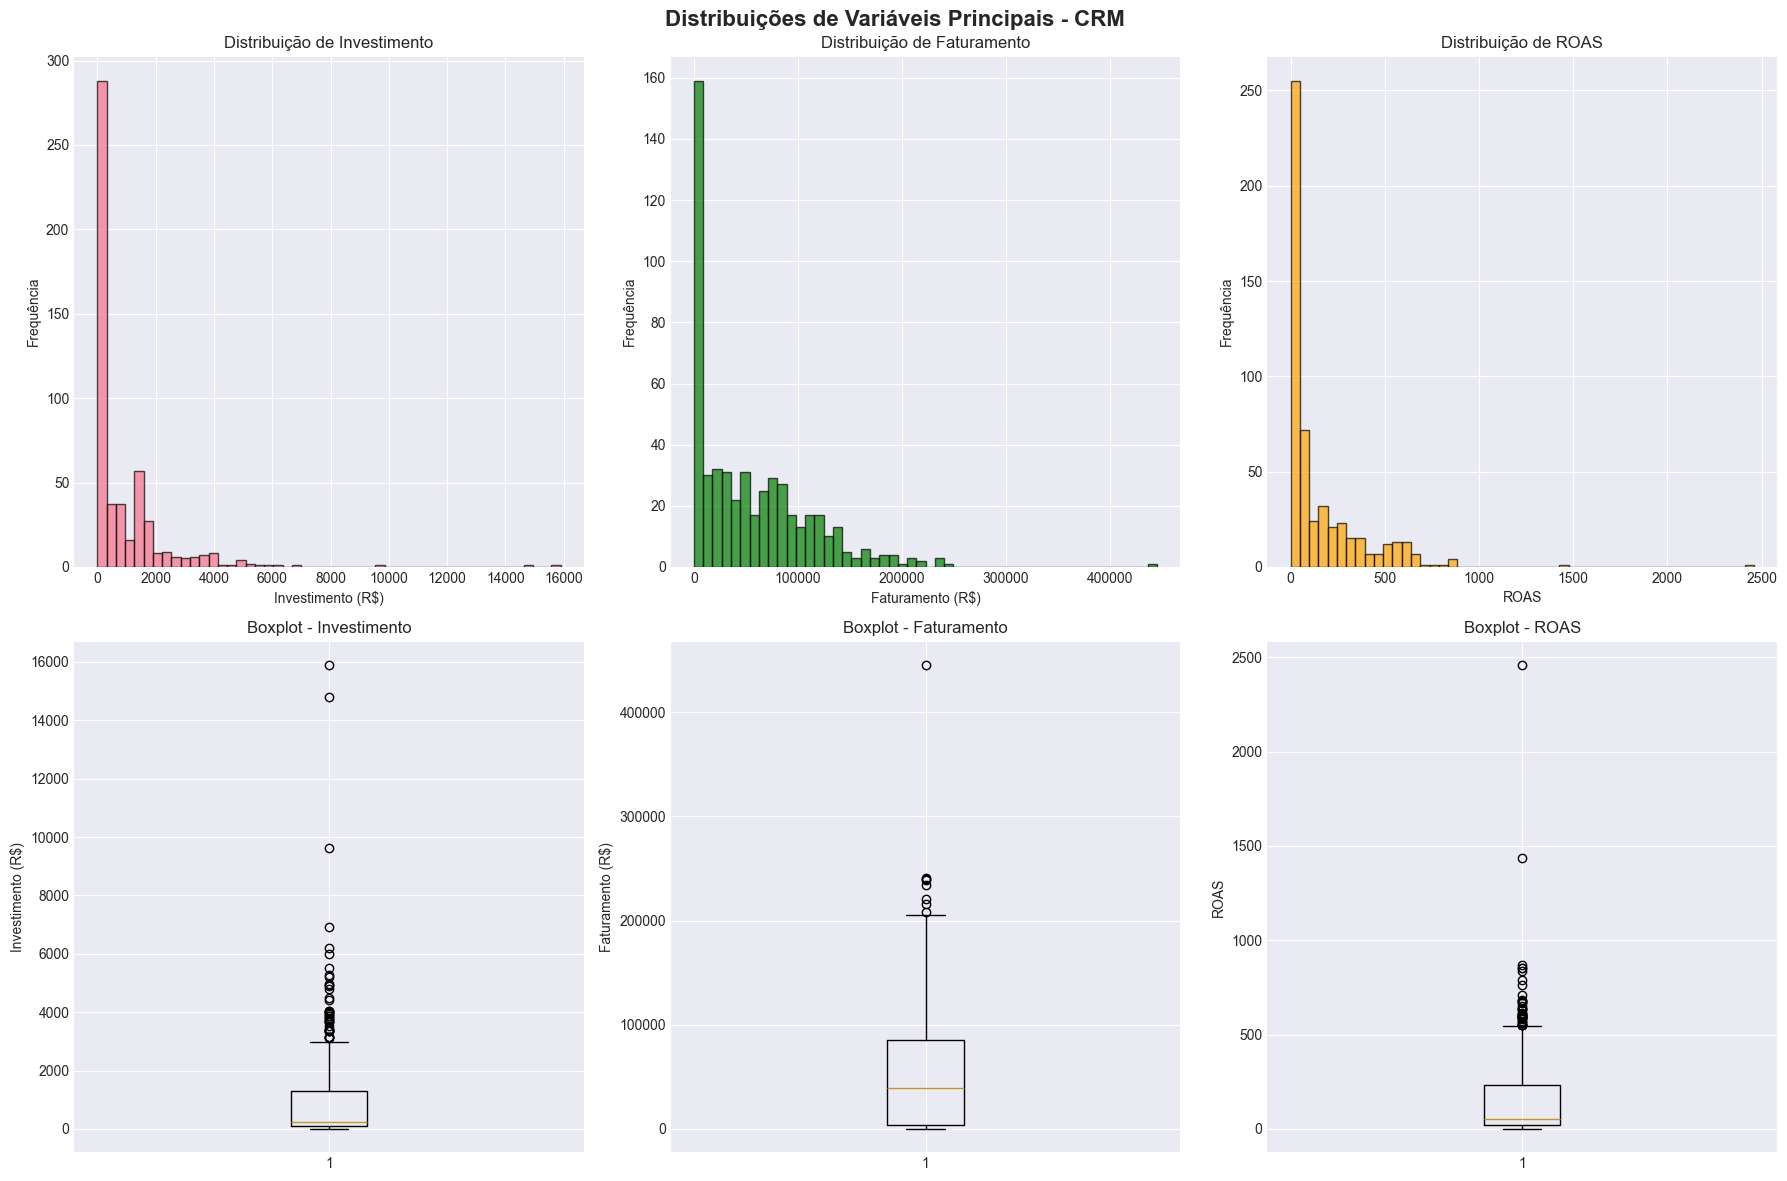

In [31]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES - DISTRIBUIÇÕES")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribuições de Variáveis Principais - CRM', fontsize=16, fontweight='bold')

axes[0, 0].hist(crm_clean['Investimento'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribuição de Investimento')
axes[0, 0].set_xlabel('Investimento (R$)')
axes[0, 0].set_ylabel('Frequência')

axes[0, 1].hist(crm_clean['Faturamento'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Distribuição de Faturamento')
axes[0, 1].set_xlabel('Faturamento (R$)')
axes[0, 1].set_ylabel('Frequência')

roas_clean = crm_clean['ROAS'].replace([np.inf, -np.inf], np.nan).dropna()
axes[0, 2].hist(roas_clean, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Distribuição de ROAS')
axes[0, 2].set_xlabel('ROAS')
axes[0, 2].set_ylabel('Frequência')

axes[1, 0].boxplot(crm_clean['Investimento'].dropna())
axes[1, 0].set_title('Boxplot - Investimento')
axes[1, 0].set_ylabel('Investimento (R$)')

axes[1, 1].boxplot(crm_clean['Faturamento'].dropna())
axes[1, 1].set_title('Boxplot - Faturamento')
axes[1, 1].set_ylabel('Faturamento (R$)')

axes[1, 2].boxplot(roas_clean)
axes[1, 2].set_title('Boxplot - ROAS')
axes[1, 2].set_ylabel('ROAS')

plt.tight_layout()
plt.show()

### Visualizações - Correlação


GERANDO VISUALIZAÇÕES - CORRELAÇÃO


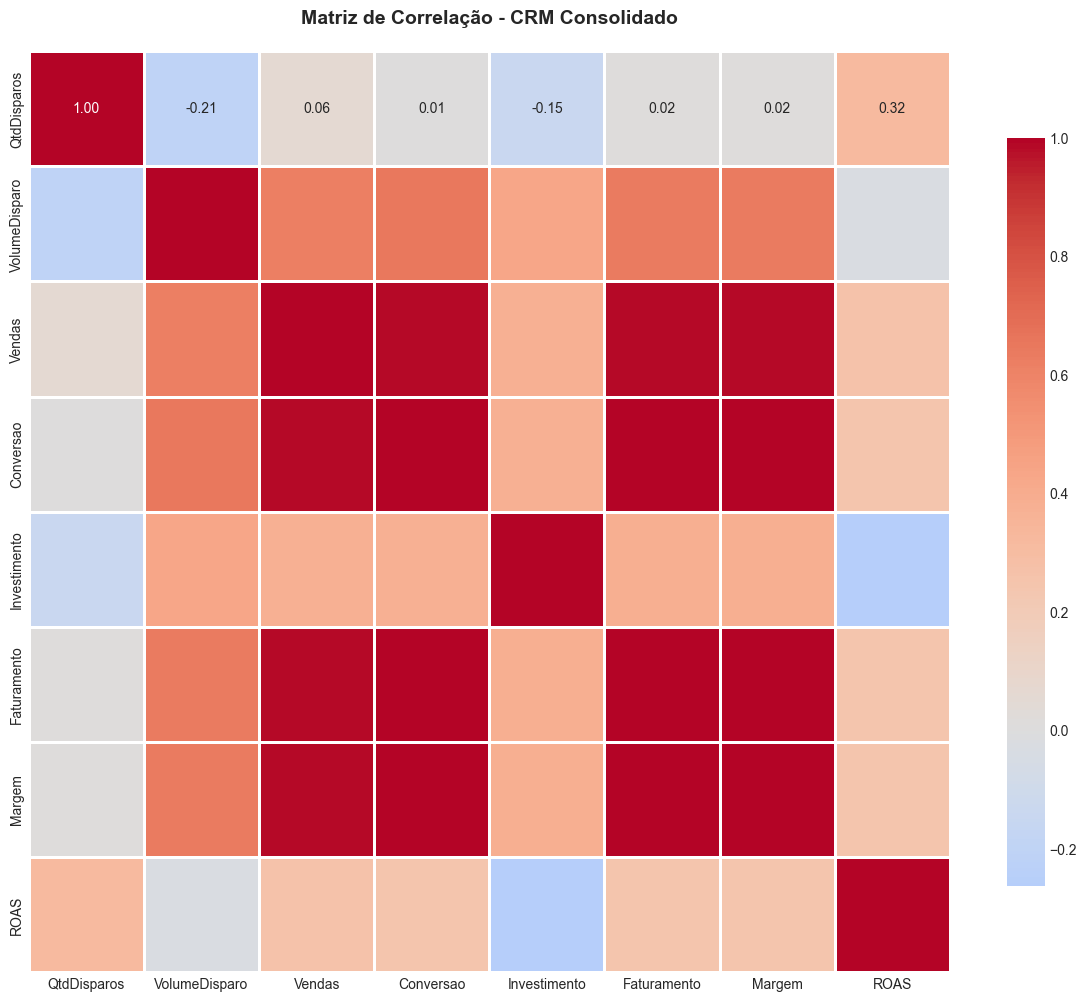

In [32]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES - CORRELAÇÃO")
print("="*80)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(matriz_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Matriz de Correlação - CRM Consolidado', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()
plt.close()

### Visualizações - Séries Temporais


GERANDO VISUALIZAÇÕES - SÉRIES TEMPORAIS


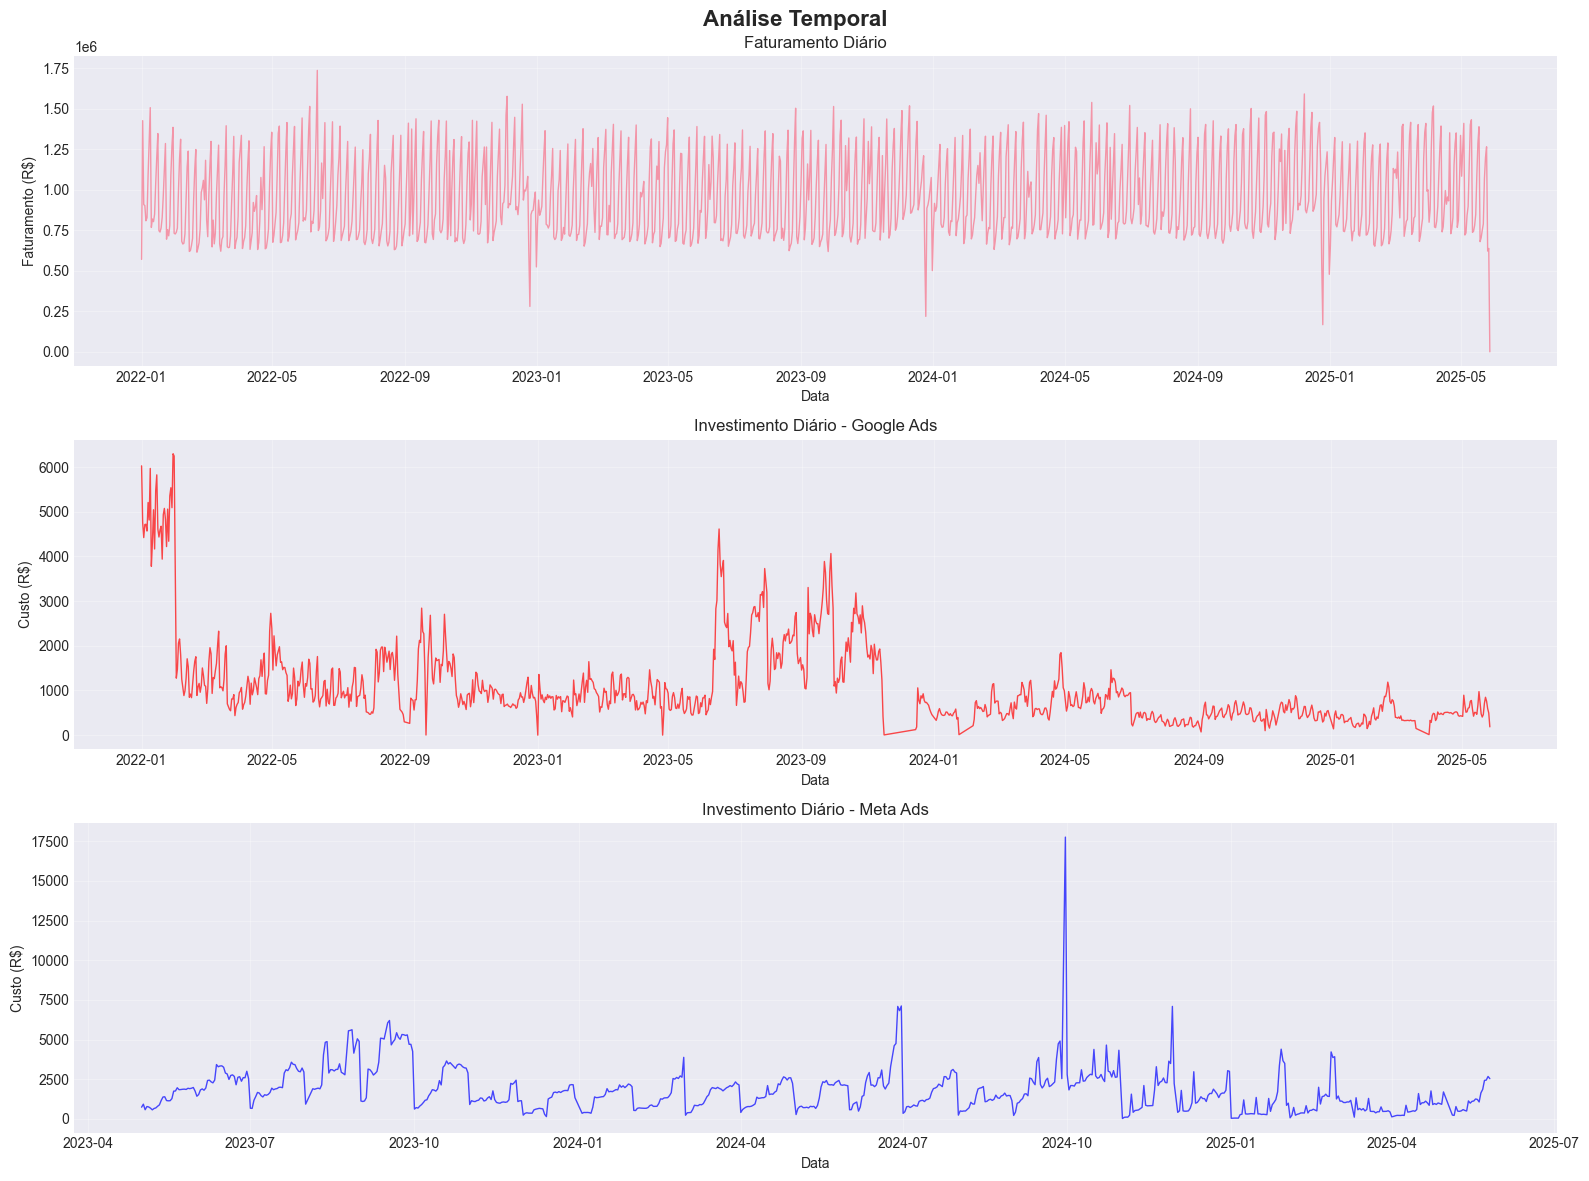

In [33]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES - SÉRIES TEMPORAIS")
print("="*80)

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Análise Temporal', fontsize=16, fontweight='bold')

faturamento_diario = faturamento_clean.groupby('time')['faturamento'].sum().sort_index()
axes[0].plot(faturamento_diario.index, faturamento_diario.values, linewidth=1, alpha=0.7)
axes[0].set_title('Faturamento Diário')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Faturamento (R$)')
axes[0].grid(True, alpha=0.3)

google_diario = google_clean.groupby('Dia')['Custo'].sum().sort_index()
axes[1].plot(google_diario.index, google_diario.values, linewidth=1, alpha=0.7, color='red')
axes[1].set_title('Investimento Diário - Google Ads')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Custo (R$)')
axes[1].grid(True, alpha=0.3)

meta_diario = meta_clean.groupby('Dia')['Valor usado (BRL)'].sum().sort_index()
axes[2].plot(meta_diario.index, meta_diario.values, linewidth=1, alpha=0.7, color='blue')
axes[2].set_title('Investimento Diário - Meta Ads')
axes[2].set_xlabel('Data')
axes[2].set_ylabel('Custo (R$)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

### Visualizações - Comparações


GERANDO VISUALIZAÇÕES - COMPARAÇÕES


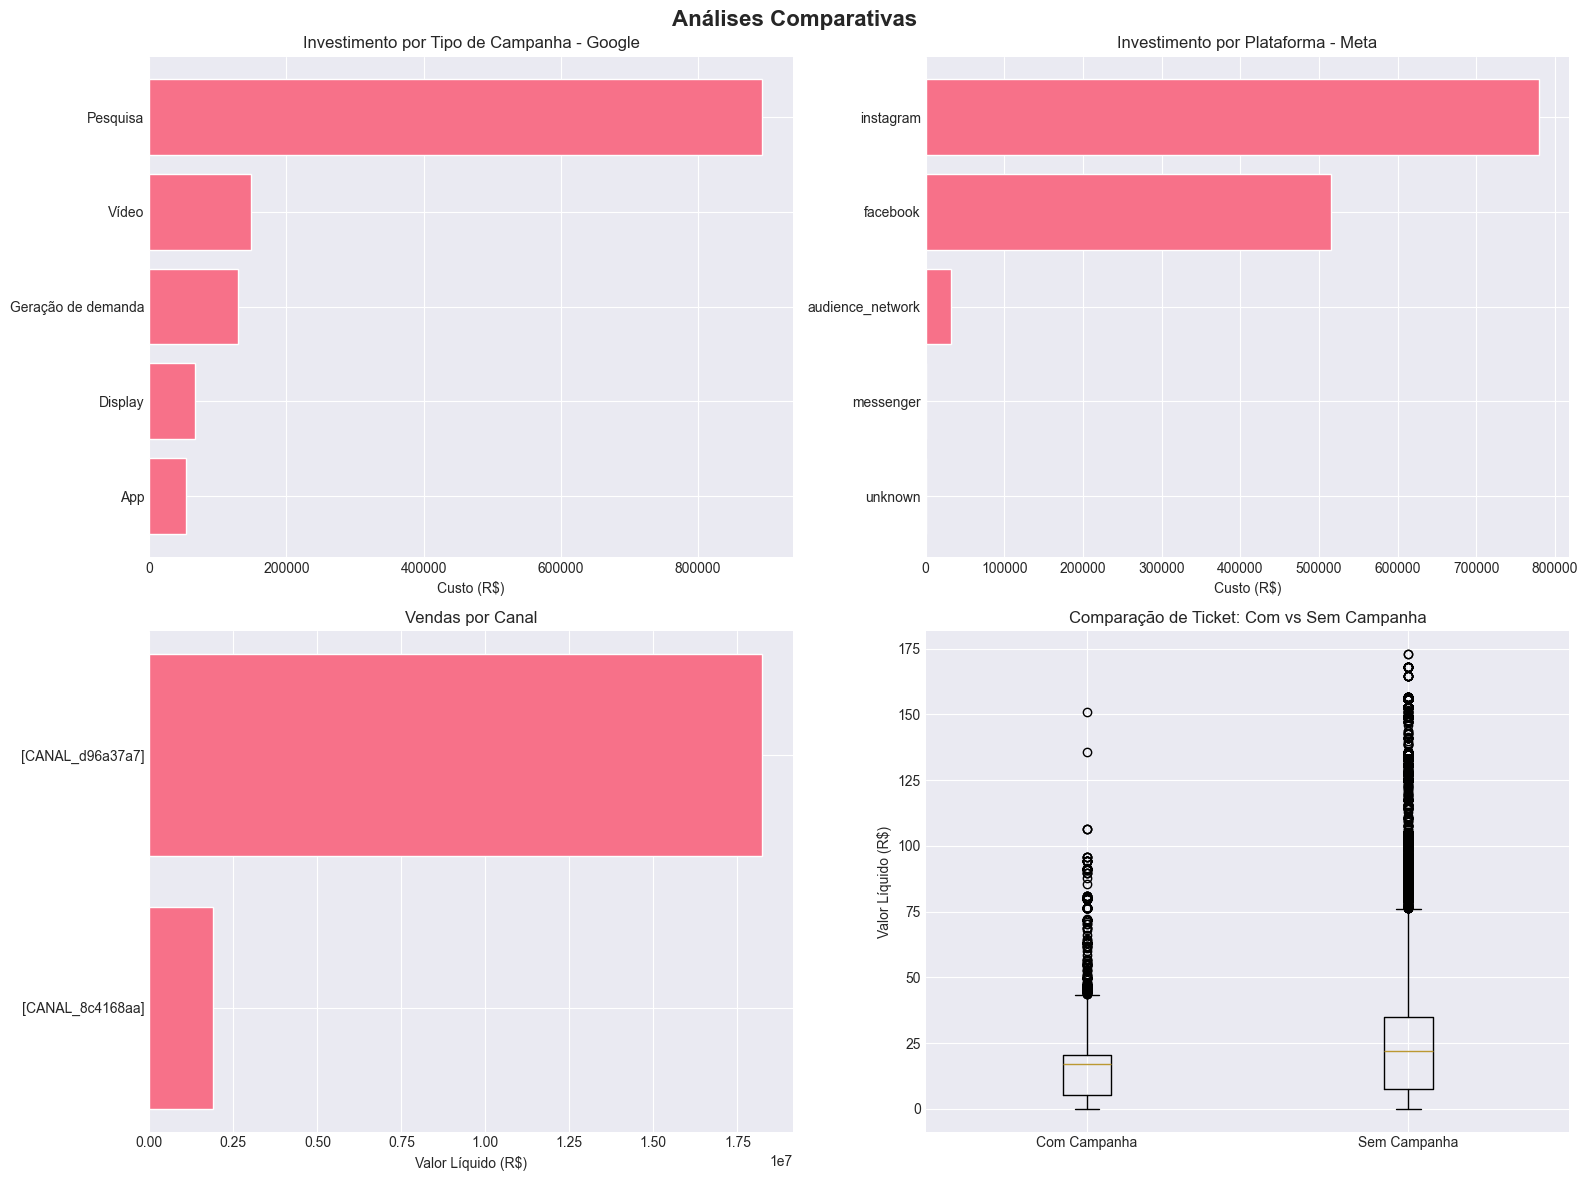

In [34]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES - COMPARAÇÕES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análises Comparativas', fontsize=16, fontweight='bold')

perf_campanha_sorted = perf_campanha.sort_values('Custo', ascending=True)
axes[0, 0].barh(perf_campanha_sorted.index, perf_campanha_sorted['Custo'])
axes[0, 0].set_title('Investimento por Tipo de Campanha - Google')
axes[0, 0].set_xlabel('Custo (R$)')

perf_plataforma_sorted = perf_plataforma.sort_values('Valor usado (BRL)', ascending=True)
axes[0, 1].barh(perf_plataforma_sorted.index, perf_plataforma_sorted['Valor usado (BRL)'])
axes[0, 1].set_title('Investimento por Plataforma - Meta')
axes[0, 1].set_xlabel('Custo (R$)')

canal_vendas = vendas_clean.groupby('Canal_Anon')['Valor Liquido'].sum().sort_values(ascending=True)
axes[1, 0].barh(canal_vendas.index, canal_vendas.values)
axes[1, 0].set_title('Vendas por Canal')
axes[1, 0].set_xlabel('Valor Líquido (R$)')

if len(vendas_com_campanha) > 0 and len(vendas_sem_campanha) > 0:
    dados_comparacao = [vendas_com_campanha['Valor Liquido'].dropna(),
                        vendas_sem_campanha['Valor Liquido'].dropna()]
    axes[1, 1].boxplot(dados_comparacao, labels=['Com Campanha', 'Sem Campanha'])
    axes[1, 1].set_title('Comparação de Ticket: Com vs Sem Campanha')
    axes[1, 1].set_ylabel('Valor Líquido (R$)')

plt.tight_layout()
plt.show()
plt.close()

### Visualizações - Scatter Plots


GERANDO VISUALIZAÇÕES - SCATTER PLOTS


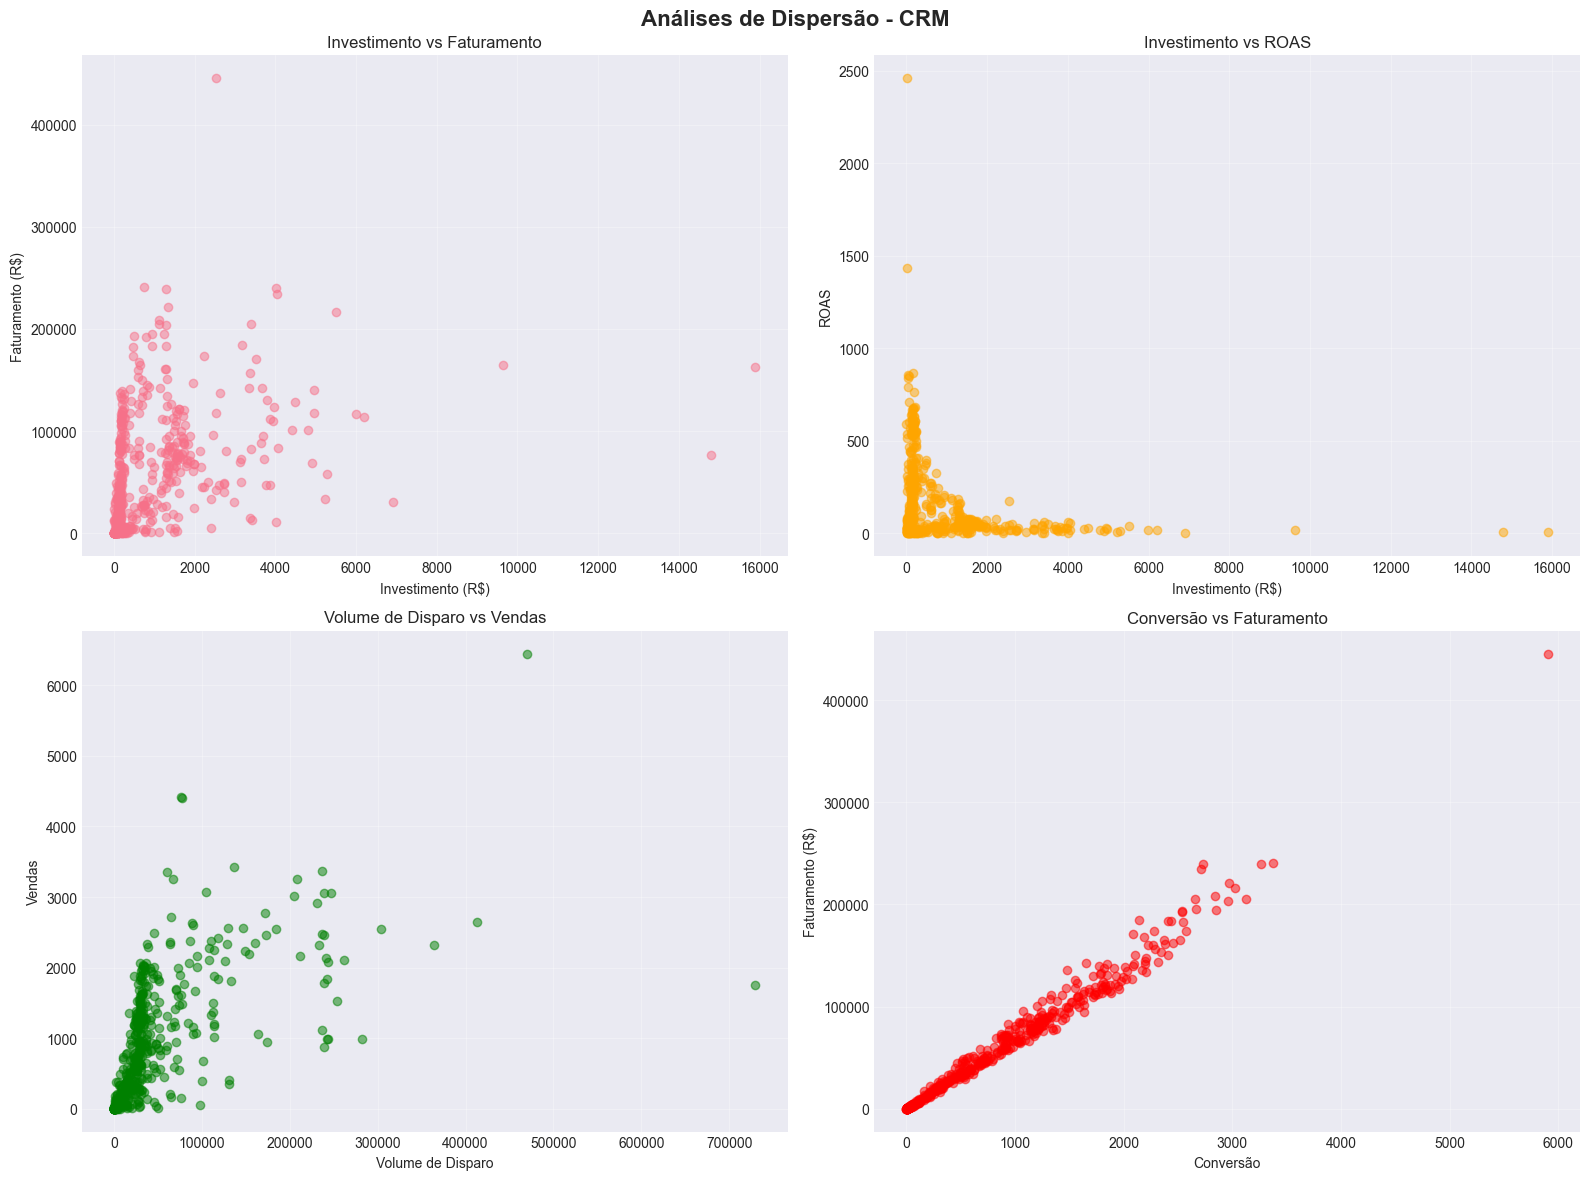

In [35]:
print("\n" + "="*80)
print("GERANDO VISUALIZAÇÕES - SCATTER PLOTS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análises de Dispersão - CRM', fontsize=16, fontweight='bold')

axes[0, 0].scatter(crm_clean['Investimento'], crm_clean['Faturamento'], alpha=0.5)
axes[0, 0].set_title('Investimento vs Faturamento')
axes[0, 0].set_xlabel('Investimento (R$)')
axes[0, 0].set_ylabel('Faturamento (R$)')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(crm_clean['Investimento'], crm_clean['ROAS'], alpha=0.5, color='orange')
axes[0, 1].set_title('Investimento vs ROAS')
axes[0, 1].set_xlabel('Investimento (R$)')
axes[0, 1].set_ylabel('ROAS')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(crm_clean['VolumeDisparo'], crm_clean['Vendas'], alpha=0.5, color='green')
axes[1, 0].set_title('Volume de Disparo vs Vendas')
axes[1, 0].set_xlabel('Volume de Disparo')
axes[1, 0].set_ylabel('Vendas')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(crm_clean['Conversao'], crm_clean['Faturamento'], alpha=0.5, color='red')
axes[1, 1].set_title('Conversão vs Faturamento')
axes[1, 1].set_xlabel('Conversão')
axes[1, 1].set_ylabel('Faturamento (R$)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

## Resumo

In [37]:
print("\n" + "="*80)
print("RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA")
print("="*80)

print("\n1. CRM CONSOLIDADO:")
print(f"   - Total de registros analisados: {len(crm_clean):,}")
print(f"   - Investimento total: R$ {crm_clean['Investimento'].sum():,.2f}")
print(f"   - Faturamento total: R$ {crm_clean['Faturamento'].sum():,.2f}")
print(f"   - ROAS médio: {crm_clean['ROAS'].mean():.2f}")
print(f"   - Correlação Investimento-Faturamento: {matriz_corr.loc['Investimento', 'Faturamento']:.4f}")

print("\n2. FATURAMENTO:")
print(f"   - Total de dias analisados: {len(faturamento_clean):,}")
print(f"   - Faturamento total: R$ {faturamento_clean['faturamento'].sum():,.2f}")
print(f"   - Faturamento médio diário: R$ {faturamento_clean['faturamento'].mean():,.2f}")
print(f"   - Coeficiente de variação: {(faturamento_clean['faturamento'].std()/faturamento_clean['faturamento'].mean()*100):.2f}%")

print("\n3. GOOGLE ADS:")
print(f"   - Total de registros: {len(google_clean):,}")
print(f"   - Investimento total: R$ {google_clean['Custo'].sum():,.2f}")
print(f"   - Total de cliques: {google_clean['Cliques'].sum():,.0f}")
print(f"   - CTR médio: {google_clean['CTR'].mean()*100:.2f}%")
print(f"   - CPC médio: R$ {google_clean['CPC'].mean():.2f}")

print("\n4. META ADS:")
print(f"   - Total de registros: {len(meta_clean):,}")
print(f"   - Investimento total: R$ {meta_clean['Valor usado (BRL)'].sum():,.2f}")
print(f"   - Total de impressões: {meta_clean['Impressões'].sum():,.0f}")
print(f"   - CPM médio: R$ {meta_clean['CPM'].mean():.2f}")

print("\n5. VENDAS:")
print(f"   - Total de itens vendidos: {len(vendas_clean):,}")
print(f"   - Valor total: R$ {vendas_clean['Valor Liquido'].sum():,.2f}")
print(f"   - Número de vendas: {vendas_clean['Id Venda'].nunique():,}")
print(f"   - Ticket médio por item: R$ {vendas_clean['Valor Liquido'].mean():.2f}")
print(f"   - Vendas com campanha: {len(vendas_com_campanha)/len(vendas_clean)*100:.2f}%")


RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA

1. CRM CONSOLIDADO:
   - Total de registros analisados: 526
   - Investimento total: R$ 479,478.71
   - Faturamento total: R$ 28,748,449.11
   - ROAS médio: inf
   - Correlação Investimento-Faturamento: 0.3846

2. FATURAMENTO:
   - Total de dias analisados: 1,244
   - Faturamento total: R$ 1,193,197,672.65
   - Faturamento médio diário: R$ 959,162.12
   - Coeficiente de variação: 26.42%

3. GOOGLE ADS:
   - Total de registros: 3,865
   - Investimento total: R$ 1,292,613.77
   - Total de cliques: 3,612,548
   - CTR médio: 12.26%
   - CPC médio: R$ 1.92

4. META ADS:
   - Total de registros: 14,068
   - Investimento total: R$ 1,327,439.23
   - Total de impressões: 291,956,163
   - CPM médio: R$ 4.93

5. VENDAS:
   - Total de itens vendidos: 978,039
   - Valor total: R$ 20,136,592.79
   - Número de vendas: 416,662
   - Ticket médio por item: R$ 20.59
   - Vendas com campanha: 17.22%
